# Lane Finding

In [1]:
# Increase the width to full screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
# Read pickle data

import pickle
camera_calibration = pickle.load(open('./pickle_data/camera_calibration.p', 'rb'))
mtx = camera_calibration['mtx']
dist = camera_calibration['dist']

import pickle
perspective_transform = pickle.load(open('./pickle_data/perspective_transform.p', 'rb'))
M = perspective_transform['M']
Minv = perspective_transform['Minv']

In [4]:
# Adding methods from color and gradient threshold

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
  # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output


def combine(gray, gradx, grady, mag_binary, dir_binary):
    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1                           
    return combined


def warp_image(undist):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


def apply_all_processing(image):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    HLS_image = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel_img = HLS_image[:,:,2]
    combined = np.zeros_like(s_channel_img)
    image = s_channel_img
    gradx = abs_sobel_thresh(image,  orient='x', thresh_min=10, thresh_max=160)
    grady = abs_sobel_thresh(image,  orient='y', thresh_min=10, thresh_max=160)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(10, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 
    return combined

def transform_and_warp(image):
    return warp_image(apply_all_processing(image))

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def FindLanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # visualize:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return left_fit, right_fit, out_img

### Skip the sliding windows step once you know where the lines are

In [6]:
def FindLanesUsingMargin(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 150
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # visualize:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    
    
    return left_fit, right_fit, out_img

## Measuring Curvature

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def GetLanePoints(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def GetCurveRadius(leftx, rightx, ploty):
    y_eval = max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, 

## Project lanes back to original image

In [8]:
def ProjectLanesOnImage(undist, binary_warped, left_fitx, right_fitx, ploty):
    image = undist

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def GetLaneRadiusDetails(left_fitx, right_fitx, ploty): 
    left_curverad, right_curverad = GetCurveRadius(left_fitx, right_fitx, ploty)
    return left_curverad, right_curverad


## Identify car location

In [9]:
import math


def AddCarLocation(image, left_fit, right_fit):
    undist =image
    car_center = undist.shape[1]/2
    y_max = undist.shape[0]

    left_lane = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_lane = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    lane_center = (left_lane + right_lane)/2

    location = ''
    difference = lane_center - car_center
    if difference > 0:
        location = 'left'
    else:
        location = 'right'

    distance = math.fabs(difference*xm_per_pix)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, '{} from center: {:.2f} m'.format(location, distance), (300,150), font, 2,(255,255,255),2)
    return image, difference


## Pipeline for video

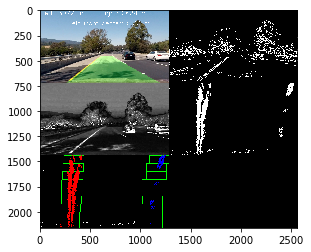

In [10]:
import copy 

def get_x(y, fit):
    x = fit[0]*y**2 + fit[1]*y + fit[2]
    return x

def get_change(current, previous):
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        self.curverad = None
        self.bottomx = None
        self.fitx = None
        self.fit = None
        self.ploty = None
        
        self.n_frames = 7
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        

class VideoPipeline():
    def __init__(self):
        self.left_lane = Lane()
        self.right_lane = Lane()
        self.left_lane = Lane()
        self.right_lane = Lane()
        self.current_image = None
        # was the line detected in the last iteration?
        self.detected = False
        # Lanes on Atleast one frame is detected.
        self.init_detection = False
        self.binary_warped_image = None
        self.frame_counter = 0
        self.combined = None
        self.s_channel_img = None
        self.detected_bin = []
        self.lane_drawn_window_img = None
        self.lane_drawn_margin_img = None
        
        
    def sanity_check(self):
        # Checking that curvature is valid.
        if self.left_lane.curverad < 200 or self.right_lane.curverad < 200:
            return False
        
        if abs(self.left_lane.bottomx - self.right_lane.bottomx) < 500:
            return False
        
        # Checking that lanes are roughly parallel.
        # We do this by checking the difference in x values of lanes for few y values.
        ymax = self.current_image.shape[1]
        y_evals = [0, ymax/2, ymax]
        diffs = []
        for y in y_evals:
            xl = get_x(y, self.left_lane.fit)
            xr = get_x(y, self.right_lane.fit)
            diffs.append(abs(xl-xr))
        if np.std(np.array(diffs)) > 300:
            return False
        # No checks failed, so return True.    
        return True
          
    def process_image_in_margins(self, image):
        self.current_image = image
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        HLS_image = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
        s_channel_img = HLS_image[:,:,2]
        combined = np.zeros_like(s_channel_img)
        gradx = abs_sobel_thresh(s_channel_img,  orient='x', thresh_min=10, thresh_max=160)
        grady = abs_sobel_thresh(s_channel_img,  orient='y', thresh_min=10, thresh_max=160)
        mag_binary = mag_thresh(s_channel_img, sobel_kernel=3, mag_thresh=(10, 150))
        dir_binary = dir_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3))
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 
        binary_warped_image = warp_image(combined)
        
        self.binary_warped_image = binary_warped_image
        self.combined = combined
        self.s_channel_img = s_channel_img
        
        self.left_lane.fit, self.right_lane.fit, self.lane_drawn_margin_img = FindLanesUsingMargin(
            binary_warped_image, self.left_lane.fit, self.right_lane.fit)
        self.left_lane.fitx, self.right_lane.fitx, ploty = GetLanePoints(
            self.left_lane.fit, self.right_lane.fit, binary_warped_image)
        self.left_lane.ploty = ploty
        self.right_lane.ploty = ploty  
        
        y_max = image.shape[0]
        self.left_lane.bottomx = get_x(y_max, self.left_lane.fit)
        self.right_lane.bottomx = get_x(y_max, self.right_lane.fit)
        
        self.left_lane.curverad, self.right_lane.curverad = (
            GetLaneRadiusDetails(self.left_lane.fitx, self.right_lane.fitx, ploty))
        self.detected = self.sanity_check()
        
        

    def update_lane_details_with_new_frames(self, multiplier):
        self.update_lane_details(self.left_lane, multiplier)
        self.update_lane_details(self.right_lane, multiplier)
            
    def update_lane_details(self, lane, multiplier):
        if(len(lane.recent_xfitted) > lane.n_frames):
            lane.recent_xfitted.pop(0)

        lane.recent_xfitted.append(lane.fitx)
        # Weighted average with higher importance to new findings
        lane.bestx = np.average(lane.recent_xfitted, axis=0, weights=range(multiplier, multiplier*len(lane.recent_xfitted)+multiplier, multiplier))
        #lane.bestx = np.mean(lane.recent_xfitted, axis=0)
        lane.best_fit = np.polyfit(lane.ploty, lane.bestx, 2)

        
    def process_image_fresh(self, image):
        self.current_image = image
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        HLS_image = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
        s_channel_img = HLS_image[:,:,2]
        combined = np.zeros_like(s_channel_img)
        gradx = abs_sobel_thresh(s_channel_img,  orient='x', thresh_min=10, thresh_max=160)
        grady = abs_sobel_thresh(s_channel_img,  orient='y', thresh_min=10, thresh_max=160)
        #mag_binary = mag_thresh(s_channel_img, sobel_kernel=3, mag_thresh=(10, 150))
        #dir_binary = dir_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3))
        combined[((gradx == 1) & (grady == 1))
                 #| ((mag_binary == 1) & (dir_binary == 1))
                ] = 1
        #combined[combined == 1] = 255        
        binary_warped_image = warp_image(combined)  
        #stacked_img = np.stack((binary_warped_image,)*3, -1)
        self.binary_warped_image = binary_warped_image
        self.combined = combined
        self.s_channel_img = s_channel_img
        
        self.left_lane.fit, self.right_lane.fit, self.lane_drawn_window_img = FindLanes(binary_warped_image)
        self.left_lane.fitx, self.right_lane.fitx, ploty = GetLanePoints(
            self.left_lane.fit, self.right_lane.fit, binary_warped_image)
        self.left_lane.ploty = ploty
        self.right_lane.ploty = ploty
        
        y_max = image.shape[0]
        self.left_lane.bottomx = get_x(y_max, self.left_lane.fit)
        self.right_lane.bottomx = get_x(y_max, self.right_lane.fit)
        
        self.left_lane.curverad, self.right_lane.curverad = (
            GetLaneRadiusDetails(self.left_lane.fitx, self.right_lane.fitx, ploty))
        self.detected = self.sanity_check()
                

    def get_multiplier(self):
        if(len(self.detected_bin) > self.left_lane.n_frames):
            self.detected_bin.pop(0)
        self.detected_bin.append(1 if self.detected else 0)
        return ((len(self.detected_bin) - sum(self.detected_bin))+1)*50 # +1 to ensure non zero
        
    def process_image(self, image):
        self.current_image = image
        
        if 'NoneType' in str(type(self.lane_drawn_window_img)):
            self.lane_drawn_window_img = np.zeros_like(image)
        if 'NoneType' in str(type(self.lane_drawn_margin_img)):
            self.lane_drawn_margin_img = np.zeros_like(image)
                
        self.frame_counter = self.frame_counter+1
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        
        # Lanes found in Previous frame.
        if len(self.left_lane.recent_xfitted):
            self.process_image_in_margins(image)
        if self.detected:
            self.update_lane_details_with_new_frames(self.get_multiplier())
        else:
            self.process_image_fresh(image)
            if self.detected:
                self.update_lane_details_with_new_frames(self.get_multiplier())
        
        if len(self.left_lane.recent_xfitted):
            undist = cv2.undistort(image, mtx, dist, None, mtx)           
            result = ProjectLanesOnImage(undist, self.binary_warped_image, self.left_lane.bestx, self.right_lane.bestx, self.left_lane.ploty)
            left_curverad, right_curverad = GetLaneRadiusDetails(self.left_lane.bestx, self.right_lane.bestx, self.left_lane.ploty)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(result, 'Left: {:04} m'.format(int(left_curverad)), (10,50), font, 2,(255,255,255),2)
            cv2.putText(result, 'Right: {:04} m'.format(int(right_curverad)), (600,50), font, 2,(255,255,255),2)
            #cv2.putText(result, str(self.frame_counter), (300,250), font, 2,(255,255,255),2)
            result, _ = AddCarLocation(result, self.left_lane.best_fit, self.right_lane.best_fit)
            return result
        # Cannot find lanes.
        return image
    
    def process_image2(self, image):
        pimage = self.process_image(image)
        combined=get_grey_3_channel_from_binary(self.combined)
        warped=get_grey_3_channel_from_binary(self.binary_warped_image)
        numpy_horizontal1 = np.hstack((pimage, combined))
        numpy_horizontal2 = np.hstack((cv2.cvtColor(self.s_channel_img, cv2.COLOR_GRAY2BGR), warped))
        numpy_horizontal3 = np.hstack((self.lane_drawn_window_img, self.lane_drawn_margin_img))
        return_image = np.vstack((numpy_horizontal1, numpy_horizontal2, numpy_horizontal3))
        return return_image
        
def get_grey_3_channel_from_binary(binary_image):
    diag = np.zeros_like(binary_image)
    diag[binary_image == 1] = 255  
    grey_3_channel = cv2.cvtColor(diag, cv2.COLOR_GRAY2BGR)
    return grey_3_channel
        

image = mpimg.imread('./test_images/test4.jpg')
result = VideoPipeline().process_image2(image)
plt.imshow(result)

## Process the video

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'video_with_lanes.mp4'
#clip2 = VideoFileClip('project_video.mp4').subclip(38,41)
clip2 = VideoFileClip('project_video.mp4')
pipeline = VideoPipeline()
process_image = pipeline.process_image2
out_clip = clip2.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_with_lanes.mp4
[MoviePy] Writing video video_with_lanes.mp4


100%|█████████▉| 1260/1261 [12:04<00:00,  1.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_with_lanes.mp4 

CPU times: user 1h 28min 11s, sys: 22.4 s, total: 1h 28min 33s
Wall time: 12min 6s


In [12]:
#Play the video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))